### Building an initial book to reccomender system
* using subset of my data 
* Top 50 movies between 1950 and 2020
* Books are the top 1000 books on the Goodreads best books list

In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import TreebankWordTokenizer
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sibongiletoure/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
movie_book_df = pd.read_pickle("sample_book_movie_df.pkl")

In [4]:
movie_book_df

,title,title_id/book_isbn,genres,release_date,plot/book_desc,year_of_release,author/director,isBook,isMovie,index,book/movie
0,Summer Stock,tt0043012,"Musical, Romance",31 August 1950,"As a favor to her actress sister Abigail, New ...",1950,Charles Walters,0,1,NaN,NaN
1,In a Lonely Place,tt0042593,"Drama, Film-Noir, Mystery",17 May 1950,Dixon Steele is a Hollywood screenwriter who h...,1950,Nicholas Ray,0,1,NaN,NaN
2,Sunset Blvd.,tt0043014,"Drama, Film-Noir",10 August 1950,Joe Gillis is a struggling hack B-movie Hollyw...,1950,Billy Wilder,0,1,NaN,NaN
3,Cinderella,tt0042332,"Animation, Family, Fantasy",15 February 1950,"In a far away, long ago kingdom, Cinderella is...",1950,"Clyde Geronimi, Wilfred Jackson, Hamilton Luske",0,1,NaN,NaN
4,All About Eve,tt0042192,Drama,13 October 1950,Stage star Margo Channing is friend to playwri...,1950,Joseph L. Mankiewicz,0,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4545,archer's voice,NaN,"Romance,New Adult,Contemporary,Romance,Contemp...",NaN,"A New York Times, USA Today, and Wall Street J...",NaN,Mia Sheridan,1,0,1000.0,NaN
4546,the complete anne of green gables boxed set,76783609419,"Classics,Fiction,Young Adult,Childrens,Histori...",NaN,"Favorites for nearly 100 years, these classic ...",NaN,L.M. Montgomery,1,0,1001.0,NaN
4547,the complete persepolis,9.78038E+12,"Sequential Art,Graphic Novels,Sequential Art,C...",NaN,"Here, in one volume: Marjane Satrapi's best-se...",NaN,"Marjane Satrapi,Mattias Ripa,Blake Ferris,Anja...",1,0,1002.0,NaN
4548,the man in the high castle,9.78068E+12,"Science Fiction,Fiction,Science Fiction,Altern...",NaN,It's America in 1962. Slavery is legal once ag...,NaN,Philip K. Dick,1,0,1003.0,NaN


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

class NLPPipe:
   
    def __init__(self, vectorizer= TfidfVectorizer(), tokenizer=None, cleaning_function=None, 
                 lemmatizer=None,model=None):
        if not tokenizer:
            tokenizer = self.splitter
        if not cleaning_function:
            cleaning_function = self.clean_text
        self.lemmatizer = lemmatizer
        self.tokenizer = tokenizer
        self.model = model
        self.cleaning_function = cleaning_function
        self.vectorizer = vectorizer
        self._is_fit = False
        
    def splitter(self, text):
        return text.split(' ')
        
 
    
    def fit_transform(self, text):
        clean_text = self.cleaning_function(text, self.tokenizer, self.lemmatizer)
        return self.vectorizer.fit_transform(clean_text)

In [7]:
def clean_text(text, tokenizer, lemmatizer):
        cities =  {"New York":"New_York",
        'Los Angeles':'Los_Angeles',
        'Hong Kong':'Hong_Kong',
        'San Fransisco':'San_Fransisco',
        'New Delhi':'New_Delhi',
        'Sao Paulo':'Sao_Paulo',
         'Mexico City':'Mexico_City'}
        text=text.str.replace(r'\d+','')
        text=text.replace(r'[^A-Za-z0-9 ]+', '', regex=True)
        cleaned_text = []
        for post in text:
            for key in cities.keys():
                if key in post:
                    post = post.replace(key, cities[key])
            post = post.replace('World War II','WWII')
            cleaned_words = []
            for word in tokenizer(post):
                low_word = word.lower()
                if lemmatizer:
                    low_word = lemmatizer.lemmatize(low_word)
                cleaned_words.append(low_word)
            cleaned_text.append(' '.join(cleaned_words))
        return cleaned_text

In [8]:
stop_words = nltk.corpus.stopwords.words('english')
languages = ['arabic','danish','dutch','english','finnish','french','german','greek','hungarian',
 'italian','kazakh', 'norwegian','portuguese','romanian','russian','slovene','spanish','swedish',
 'turkish']
for l in languages:
    stop_words.extend(nltk.corpus.stopwords.words(l))
new_stopwords = ['want','ha','ca','ago','know','may','would','go'\
               ,'wa','also','old','year','two','one',\
               'film', 'movie', 'feature', 'director', 'short', 'filmmaker', 'character', 'star', 'comedy', 'based',\
                'story', 'based', 'tells', 'true', 'directed','find','way','must','meet',\
               'de', 'la', 'un', 'su', 'en', 'el', 'que', 'una', 'se', 'le','three',
               'time', 'day', 'take', 'people', 'make', 'first', 'come', 'work', 'place', 'night',\
               'yearold','dy','little','named','back','doe','tell','get','hi','thi','becomes',
               'book', 'novel', 'reader', 'author', 'series', 'read', 'written', 'history', 'edition',\
                'edition',  'bestselling', 'reader','published','set', 'text', 'drama', 'classic','literary','bestseller','academy','award']
stop_words.extend(new_stopwords)
stop_words = set(stop_words) 

In [9]:
corpus = movie_book_df['plot/book_desc']

### Due to the differences in the genres will base the reccomender fully on the vectors and there cosine similarity
* This first reccomender I will be using TFIDF and the same data and cosine similarity

In [24]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(corpus)

/Users/sibongiletoure/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['printr', 'δι', 'арбаң', 'арсалаң', 'батыр', 'бүгжең', 'бұтыр', 'далаң', 'ербелең', 'жалт', 'жұлт', 'күңгір', 'митың', 'онан', 'паһ', 'салаң', 'сұлаң', 'сұрт', 'тарбаң', 'тыржың', 'тұрс', 'шұңқ', 'ыржың', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'әттеген', 'ἀλλ'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [25]:
tf_result.shape

(4550, 333035)

In [26]:
ex_label = [c[:30]+"..." for c in corpus]

In [27]:
pd.DataFrame(tf_result.toarray(), index=ex_label, columns=nlp.vectorizer.get_feature_names()).head(10)

,aa,aa birthday,aa community,aa meeting,aaa,aaa package,aames,aames jr,aames sr,aarfa,...,zuzu,zuzu petal,zwerga,zwerga dwarfshort,zy,zy learn,zylska,zylska poland,zyra,zyra planet
As a favor to her actress sist...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Dixon Steele is a Hollywood sc...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Joe Gillis is a struggling hac...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"In a far away, long ago kingdo...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Stage star Margo Channing is f...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Based out of Newport, Californ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sheltering from a rainstorm in...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Civil War veteran Josiah Grey ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A reformed Gunfighter Jimmy Ri...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rio Grande takes place after t...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
from sklearn.metrics.pairwise import cosine_similarity
def recommendations(title):
    cosine_similarities = cosine_similarity(tf_result, tf_result)

    # taking the title and book image link and store in new data frame called books
    movies = movie_book_df[movie_book_df['isMovie']==1]['title']
    #books = movie_book_df['title']
    #Reverse mapping of the index
    indices = pd.Series(movie_book_df.index, index = movie_book_df['title'])
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores  = [score for score in sim_scores if movie_book_df.iloc[score[0]]['isMovie']==1]
    sim_scores = sim_scores[1:6]
    print(sim_scores)
    movie_indices = [i[0] for i in sim_scores]
    print(movie_indices)
    recommend = movies.iloc[movie_indices]
    return recommend

In [29]:
reccomend = recommendations('the perks of being a wallflower')

[(536, 0.05610520813694901), (1915, 0.055081789114104496), (1643, 0.05410213082970285), (1848, 0.05336475296477882), (1305, 0.04733793727326814)]
[536, 1915, 1643, 1848, 1305]


In [30]:
reccomend

536     Shoot the Piano Player
1915                  Rain Man
1643                   Missing
1848            Something Wild
1305                     Rocky
Name: title, dtype: object

In [31]:
reccomend = recommendations('the lord of the rings')

[(2665, 0.21712109861753992), (2606, 0.21338926674035724), (774, 0.14703786608475003), (15, 0.12385549472840644), (3192, 0.08026761637164366)]
[2665, 2606, 774, 15, 3192]


In [32]:
reccomend

2665    The Lord of the Rings: The Return of the King
2606            The Lord of the Rings: The Two Towers
774                                             Help!
15                                             Sierra
3192              The Hobbit: The Desolation of Smaug
Name: title, dtype: object

In [33]:
reccomend = recommendations('harry potter and the order of the phoenix')

[(2758, 0.061840236555834954), (3085, 0.057522745604692456), (2867, 0.04886634983231948), (2604, 0.04844953174588035), (2788, 0.04752324714050783)]
[2758, 3085, 2867, 2604, 2788]


In [34]:
reccomend

2758             Harry Potter and the Goblet of Fire
3085    Harry Potter and the Deathly Hallows: Part 2
2867       Harry Potter and the Order of the Phoenix
2604         Harry Potter and the Chamber of Secrets
2788                             Kiss Kiss Bang Bang
Name: title, dtype: object

In [35]:
reccomend = recommendations('gone with the wind')

[(3472, 0.0388365386642882), (2195, 0.035739519536934224), (566, 0.030157059023040646), (3344, 0.02958650573525111), (1299, 0.02808016745628607)]
[3472, 2195, 566, 3344, 1299]


In [36]:
reccomend

3472           Little Women
2195             Gettysburg
566         One, Two, Three
3344    Free State of Jones
1299      Let's Do It Again
Name: title, dtype: object

## TFIDF reccomender with different hyperparameters
* The recommender seems to work pretty well so far giving me civil war movies for Gone with the wind and a Harry potter movie for harry potter but I want to see if adding a min df makes an improvement

In [37]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,min_df=0.01,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(corpus)

/Users/sibongiletoure/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['printr', 'δι', 'арбаң', 'арсалаң', 'батыр', 'бүгжең', 'бұтыр', 'далаң', 'ербелең', 'жалт', 'жұлт', 'күңгір', 'митың', 'онан', 'паһ', 'салаң', 'сұлаң', 'сұрт', 'тарбаң', 'тыржың', 'тұрс', 'шұңқ', 'ыржың', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'әттеген', 'ἀλλ'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [38]:
def recommendations(title):
    
    # Calling the function vectors

    #vectors(corpus)
    
    # finding cosine similarity for the vectors
    cosine_similarities = cosine_similarity(tf_result, tf_result)

    # taking the title and book image link and store in new data frame called books
    movies = movie_book_df[movie_book_df['isMovie']==1]['title']
    #books = movie_book_df['title']
    #Reverse mapping of the index
    indices = pd.Series(movie_book_df.index, index = movie_book_df['title'])
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores  = [score for score in sim_scores if movie_book_df.iloc[score[0]]['isMovie']==1]
    sim_scores = sim_scores[1:6]
    print(sim_scores)
    movie_indices = [i[0] for i in sim_scores]
    print(movie_indices)
    recommend = movies.iloc[movie_indices]
    return recommend

In [42]:
reccomend = recommendations('gone with the wind')

[(7, 0.20704917664478942), (824, 0.20026430216677407), (2859, 0.1972068745959918), (1025, 0.19367734420615118), (1941, 0.19173447974085198)]
[7, 824, 2859, 1025, 1941]


In [43]:
reccomend

7         Stars in My Crown
824     Au Hasard Balthazar
2859    Mother of the Dunes
1025                 Chisum
1941       Oliver & Company
Name: title, dtype: object

In [44]:
reccomend = recommendations('harry potter and the order of the phoenix')

[(2553, 0.29146924525067663), (705, 0.28318131315357287), (254, 0.27831013312059866), (2934, 0.27248204866814224), (1880, 0.26742557471616635)]
[2553, 705, 254, 2934, 1880]


In [45]:
reccomend

2553    Harry Potter and the Sorcerer's Stone
705                                Dear Heart
254                   The Night of the Hunter
2934                       Burn After Reading
1880                              Angel Heart
Name: title, dtype: object

In [46]:
reccomend = recommendations('the boy in the striped pajamas')

[(547, 0.22291771561379453), (1904, 0.19563234460719156), (134, 0.19239367642159144), (251, 0.19215787169200202), (572, 0.18367422619118262)]
[547, 1904, 134, 251, 572]


In [47]:
reccomend

547     Please Don't Eat the Daisies
1904                     Beetlejuice
134                      The Big Sky
251            Rebel Without a Cause
572                   Scream of Fear
Name: title, dtype: object

## TFIDF with Max_df
* The recommender is ok with the min_df but does worse on book series like Harry potter 

In [49]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,max_df=0.5,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(corpus)

In [51]:
reccomend = recommendations('harry potter and the order of the phoenix')
reccomend

[(2758, 0.061840236555834954), (3085, 0.057522745604692456), (2867, 0.04886634983231948), (2604, 0.04844953174588035), (2788, 0.04752324714050783)]
[2758, 3085, 2867, 2604, 2788]


2758             Harry Potter and the Goblet of Fire
3085    Harry Potter and the Deathly Hallows: Part 2
2867       Harry Potter and the Order of the Phoenix
2604         Harry Potter and the Chamber of Secrets
2788                             Kiss Kiss Bang Bang
Name: title, dtype: object

In [54]:
recommend = recommendations('gone with the wind')
recommend

[(3472, 0.0388365386642882), (2195, 0.035739519536934224), (566, 0.030157059023040646), (3344, 0.02958650573525111), (1299, 0.02808016745628607)]
[3472, 2195, 566, 3344, 1299]


3472           Little Women
2195             Gettysburg
566         One, Two, Three
3344    Free State of Jones
1299      Let's Do It Again
Name: title, dtype: object

## Try Recommender for all books DO NOT RUN 

In [55]:
book_movie_df = pd.read_pickle("book_movie_df.pkl")

In [56]:
full_corpus = book_movie_df['plot/book_desc']

In [57]:
book_movie_df

,title,title_id/book_isbn,genres,release_date,plot/book_desc,year_of_release,author/director,isBook,isMovie,index,book/movie
0,Summer Stock,tt0043012,"Musical, Romance",31 August 1950,"As a favor to her actress sister Abigail, New ...",1950,Charles Walters,0,1,NaN,NaN
1,In a Lonely Place,tt0042593,"Drama, Film-Noir, Mystery",17 May 1950,Dixon Steele is a Hollywood screenwriter who h...,1950,Nicholas Ray,0,1,NaN,NaN
2,Sunset Blvd.,tt0043014,"Drama, Film-Noir",10 August 1950,Joe Gillis is a struggling hack B-movie Hollyw...,1950,Billy Wilder,0,1,NaN,NaN
3,Cinderella,tt0042332,"Animation, Family, Fantasy",15 February 1950,"In a far away, long ago kingdom, Cinderella is...",1950,"Clyde Geronimi, Wilfred Jackson, Hamilton Luske",0,1,NaN,NaN
4,All About Eve,tt0042192,Drama,13 October 1950,Stage star Margo Channing is friend to playwri...,1950,Joseph L. Mankiewicz,0,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
83982,running the books: the adventures of an accide...,9.78039E+12,"Nonfiction,Autobiography,Memoir,Biography,Writ...",NaN,Avi Steinberg is stumped. After defecting from...,NaN,Avi Steinberg,1,0,42722.0,NaN
83983,taking the field: a fan's quest to run the tea...,9.78161E+12,"Sports,Baseball,Sports and Games,Sports,Nonfic...",NaN,"In this fearless and half-crazy story, Howard ...",NaN,Howard Megdal,1,0,42723.0,NaN
83984,"the baseball talmud: koufax, greenberg, and th...",9.78006E+12,"Nonfiction,Sports and Games,Sports",NaN,From the icons of the game to the players who ...,NaN,Howard Megdal,1,0,42724.0,NaN
83985,he wanted the moon: the madness and medical ge...,9.7808E+12,"Nonfiction,Autobiography,Memoir,Biography,Psyc...",NaN,"Soon to be a major motion picture, from Brad P...",NaN,"Mimi Baird,Eve Claxton",1,0,42725.0,NaN


In [58]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(full_corpus)

/Users/sibongiletoure/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['printr', 'δι', 'арбаң', 'арсалаң', 'батыр', 'бүгжең', 'бұтыр', 'далаң', 'ербелең', 'жалт', 'жұлт', 'күңгір', 'митың', 'онан', 'паһ', 'салаң', 'сұлаң', 'сұрт', 'тарбаң', 'тыржың', 'тұрс', 'шұңқ', 'ыржың', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'әттеген', 'ἀλλ'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [34]:
# from sklearn.decomposition import TruncatedSVD
# n_comp = [4,10,15,20,50,100,150,200,500,700,800,900,1000,1500,2000,2500,3000,3500] # list containing different values of components
# explained = [] # explained variance ratio for each component of Truncated SVD
# for x in n_comp:
#     svd = TruncatedSVD(n_components=x)
#     svd.fit(tf_result)
#     explained.append(svd.explained_variance_ratio_.sum())
#     print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
# plt.plot(n_comp, explained)
# plt.xlabel('Number of components')
# plt.ylabel("Explained Variance")
# plt.title("Plot of Number of components v/s explained variance")
# plt.show()

In [59]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,min_df=0.1,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(full_corpus)

In [60]:
tf_result.shape

(83987, 13)

In [61]:
reccomend = recommendations('the lord of the rings')

RuntimeError: nnz of the result is too large

## Word2Vec Reccomender w/ full corpus

In [62]:
import gensim.downloader as api
from gensim.test.utils import datapath

model = api.load('word2vec-google-news-300')

In [63]:
full_corpus = book_movie_df['plot/book_desc']

In [64]:
full_corpus = clean_text(full_corpus,tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

In [65]:
def vectors(x):
    
    # Creating a list for storing the vectors (description into vectors)
    global word_embeddings
    word_embeddings = []

    # Reading the each book description 
    for line in full_corpus:
        avgword2vec = None
        count = 0
        for word in line.split():
            #print(word)
            if word in model:
                count += 1
                if avgword2vec is None:
                    avgword2vec = model[word]
                else:
                    avgword2vec = avgword2vec + model[word]
                
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
        
            word_embeddings.append(avgword2vec)

In [119]:
len(word_embeddings)

83985

In [66]:
def recommendations(title):
    
    # Calling the function vectors

    vectors(full_corpus)
    
    # finding cosine similarity for the vectors

    cosine_similarities = cosine_similarity(word_embeddings, word_embeddings)

    # taking the title and book image link and store in new data frame called books
    movies = book_movie_df[book_movie_df['isMovie']==1][['title','author/director','release_date']]
    #books = movie_book_df['title']
    #Reverse mapping of the index
    indices = pd.Series(book_movie_df.index, index = book_movie_df['title'])
    print(len(indices))
         
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores  = [score for score in sim_scores if book_movie_df.iloc[score[0]]['isMovie']==1]
    sim_scores = sim_scores[1:6]
    print(sim_scores)
    movie_indices = [i[0] for i in sim_scores]
    print(movie_indices)
    recommend = movies.iloc[movie_indices]
    return recommend

In [67]:
reccomend = recommendations('the lord of the rings')

83987
[(28703, 0.9184871), (36606, 0.9179005), (37255, 0.91404814), (30058, 0.91396046), (18789, 0.9135915)]
[28703, 36606, 37255, 30058, 18789]


In [68]:
reccomend

,title,author/director,release_date
28703,The Hobbit: An Unexpected Journey,Peter Jackson,28 November 2012
36606,Les Seigneurs d'Outre Monde,Rémi Hoffmann,22 May 2016
37255,Doraemon: Great Adventure in the Antarctic Kac...,Atsushi Takahashi,4 March 2017
30058,The Hobbit: The Desolation of Smaug,Peter Jackson,2 December 2013
18789,The Lord of the Rings: The Two Towers,Peter Jackson,5 December 2002


In [69]:
reccomend = recommendations('gone with the wind')

83987
[(991, 0.9019112), (34155, 0.9003285), (29559, 0.90003717), (13218, 0.8948716), (14199, 0.8935751)]
[991, 34155, 29559, 13218, 14199]


In [70]:
reccomend

,title,author/director,release_date
991,Koibumi,Kinuyo Tanaka,13 December 1953
34155,Todos se van,Sergio Cabrera,13 March 2015
29559,Dom s bashenkoy,"Eva Neymann, Ludmila Kulchitskaya, Ivan Rutkov...",17 June 2012
13218,Circles in a Forest,Regardt van den Bergh,18 August 1989
14199,Orlando,Sally Potter,1 September 1992


In [71]:
reccomend = recommendations('harry potter and the order of the phoenix')

83987
[(36606, 0.92778933), (35872, 0.92478484), (34919, 0.9216463), (41853, 0.9213949), (36336, 0.9201003)]
[36606, 35872, 34919, 41853, 36336]


In [72]:
reccomend

,title,author/director,release_date
36606,Les Seigneurs d'Outre Monde,Rémi Hoffmann,22 May 2016
35872,Before 'I Do',Kimberly Conner,23 June 2016
34919,Midnight Special,Jeff Nichols,12 February 2016
41853,The Invisible Man,Leigh Whannell,24 February 2020
36336,Ya no es antes,Lester Hamlet,December 2016


* Word2Vec has works on full corpus although tfidf does not I will try TFIDF on a larger corpus than the sample but smaller than the entire corpus

## TFIDF not working w/ full corpus will try with top 200 movies per year and top 2000 books

In [73]:
movie_book_df2 = pd.read_pickle('sample_data2.pkl')

In [74]:
corpus = movie_book_df2['plot/book_desc']

In [75]:
corpus 

0        As a favor to her actress sister Abigail, New ...
1        Dixon Steele is a Hollywood screenwriter who h...
2        Joe Gillis is a struggling hack B-movie Hollyw...
3        In a far away, long ago kingdom, Cinderella is...
4        Stage star Margo Channing is friend to playwri...
                               ...                        
16195    In Tokyo, sixteen-year-old Nao has decided the...
16196    Wrapped in the landscape of a blustery Wiscons...
16197    One of the most popular and critically acclaim...
16198    Kacey Cleary’s whole life imploded four years ...
16199    The Complete Stories brings together all of Ka...
Name: plot/book_desc, Length: 16200, dtype: object

In [76]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,min_df=0.01,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(corpus)


/Users/sibongiletoure/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['printr', 'δι', 'арбаң', 'арсалаң', 'батыр', 'бүгжең', 'бұтыр', 'далаң', 'ербелең', 'жалт', 'жұлт', 'күңгір', 'митың', 'онан', 'паһ', 'салаң', 'сұлаң', 'сұрт', 'тарбаң', 'тыржың', 'тұрс', 'шұңқ', 'ыржың', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'әттеген', 'ἀλλ'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [77]:
cosine_similarities = cosine_similarity(tf_result, tf_result)

In [78]:
def recommendations(title):
    
    cosine_similarities

    # taking the title and book image link and store in new data frame called books
    movies = movie_book_df2[movie_book_df2['isMovie']==1]['title']
    #books = movie_book_df['title']
    #Reverse mapping of the index
    indices = pd.Series(movie_book_df2.index, index = movie_book_df2['title'])
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores  = [score for score in sim_scores if movie_book_df2.iloc[score[0]]['isMovie']==1]
    sim_scores = sim_scores[1:6]
    print(sim_scores)
    movie_indices = [i[0] for i in sim_scores]
    print(movie_indices)
    recommend = movies.iloc[movie_indices]
    return recommend

In [79]:
reccomend = recommendations('the lord of the rings')

[(1410, 0.4274269381352255), (9580, 0.36736808005516464), (10615, 0.3346982001756854), (3308, 0.3165006491416994), (2475, 0.31610210994543253)]
[1410, 9580, 10615, 3308, 2475]


In [80]:
reccomend

1410                                   Throne of Blood
9580                                         Annamayya
10615    The Lord of the Rings: The Return of the King
3308                                          Daimajin
2475                                       Chûshingura
Name: title, dtype: object

In [81]:
reccomend = recommendations('gone with the wind')

[(3776, 0.28124024330870817), (3955, 0.2482269413212196), (5548, 0.2461818205268928), (4216, 0.24564528113136166), (4025, 0.23236918888301866)]
[3776, 3955, 5548, 4216, 4025]


In [82]:
reccomend

3776                             Täällä Pohjantähden alla
3955    Il Prof. Dott. Guido Tersilli primario della C...
5548                             Coz takhle dát si spenát
4216                                         The Beguiled
4025                                               Chisum
Name: title, dtype: object

In [83]:
reccomend = recommendations('little women')

[(8541, 0.30901089684283145), (6547, 0.2976776375280395), (8776, 0.2888698998003088), (4592, 0.28492332486220284), (7318, 0.27056460585768694)]
[8541, 6547, 8776, 4592, 7318]


In [84]:
reccomend

8541         Les nuits fauves
6547    We of the Never Never
8776       Jamba Lakidi Pamba
4592             A Free Woman
7318                   Nagina
Name: title, dtype: object

### The reccomender seems to have better predictions when it has a max_df

In [85]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words, max_df = 0.5,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(corpus)

In [86]:
cosine_similarities = cosine_similarity(tf_result, tf_result)

In [87]:
reccomend = recommendations('the lord of the rings')
reccomend

[(10406, 0.20874679459441844), (10615, 0.2087295206486218), (3024, 0.13232971208393163), (12450, 0.11575592464004247), (15, 0.11041678517261262)]
[10406, 10615, 3024, 12450, 15]


10406            The Lord of the Rings: The Two Towers
10615    The Lord of the Rings: The Return of the King
3024                                             Help!
12450                The Hobbit: An Unexpected Journey
15                                              Sierra
Name: title, dtype: object

In [88]:
reccomend = recommendations('harry potter and the order of the phoenix')
reccomend

[(11008, 0.06349597464357479), (12235, 0.05850110933320968), (10404, 0.049464965163711794), (11417, 0.048918255934363726), (11038, 0.04714034576834944)]
[11008, 12235, 10404, 11417, 11038]


11008             Harry Potter and the Goblet of Fire
12235    Harry Potter and the Deathly Hallows: Part 2
10404         Harry Potter and the Chamber of Secrets
11417       Harry Potter and the Order of the Phoenix
11038                             Kiss Kiss Bang Bang
Name: title, dtype: object

In [89]:
reccomend = recommendations('memoirs of a geisha')
reccomend

[(11046, 0.04604783150159214), (1326, 0.04138396260279443), (721, 0.03276340933773381), (920, 0.03159920106929408), (4534, 0.028217308993342394)]
[11046, 1326, 721, 920, 4534]


11046    Memoirs of a Geisha
1326                Nagareru
721                 A Geisha
920      The Woman of Rumour
4534       Money Money Money
Name: title, dtype: object

In [90]:
reccomend = recommendations('the hobbit')
reccomend

[(10204, 0.08035575063088221), (13835, 0.07390056514699475), (10406, 0.059509433559157186), (10615, 0.03939591165109408), (13883, 0.03858590730260918)]
[10204, 13835, 10406, 10615, 13883]


10204    The Lord of the Rings: The Fellowship of the Ring
13835                                         The Platform
10406                The Lord of the Rings: The Two Towers
10615        The Lord of the Rings: The Return of the King
13883                                              Tolkien
Name: title, dtype: object

In [91]:
reccomend = recommendations('gone with the wind')

[(12931, 0.04229076858130909), (1010, 0.0395379937964015), (7723, 0.038827178642830626), (4594, 0.038541261063899726), (7459, 0.03551871231189926)]
[12931, 1010, 7723, 4594, 7459]


In [92]:
reccomend 

12931    Mr. Peabody & Sherman
1010       The Seven Year Itch
7723          The Little Thief
4594          Georgia, Georgia
7459            House of Games
Name: title, dtype: object

In [93]:
reccomend = recommendations('little women')


[(8816, 0.09191622951710574), (6917, 0.047537692824547666), (9002, 0.04504364249400031), (12987, 0.04149899059507992), (1068, 0.0412828448890658)]
[8816, 6917, 9002, 12987, 1068]


In [94]:
reccomend 

8816            Little Women
6917     Klassenverhältnisse
9002      Indradhanura Chhai
12987                4 Moons
1068        My Sister Eileen
Name: title, dtype: object

## Reccomender w/ max_df

In [95]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,max_df=0.5,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(corpus)

In [96]:
tf_result.shape

(16200, 882498)

In [97]:
 cosine_similarities = cosine_similarity(tf_result, tf_result)

In [98]:
import numpy as np
# get pairwise distances from array or df
#song_similarities = pairwise_distances(pca_data[:,:8])
# find the nth percentile distance so you can set the rest to zero
np.percentile( cosine_similarities[:,0],1)

# whatever the value is at that percentile, set everything above that equal to zero
cos_dist_df = pd.DataFrame(cosine_similarities)
cos_dist_df[cos_dist_df>1.5] = 0

# make sparse matrix
import scipy.sparse
sparse_mat = scipy.sparse.csc_matrix(cos_dist_df)




# you can index off of the sparse matrix as long as you cast it toarray()
sparse_mat[:,445].toarray()

# I used this to get the indexes of the 20 closest songs
result = pd.DataFrame(sparse_mat[:,14593].toarray()).sort_values(by=0,ascending=False).head(20).index

In [99]:
result = pd.DataFrame(sparse_mat[:,14368].toarray()).sort_values(by=0,ascending=False).head(20)

In [101]:
# import pickle
# pickle.dump(sparse_mat, open("sparse.pkl", "wb"))
#myobj2 = cPickle.load(open("myfile.pickle"))

In [102]:
def recommendations(title):
    
    # Calling the function vectors

    #vectors(corpus)
    
    # finding cosine similarity for the vectors
    #cosine_similarities = cosine_similarity(tf_result, tf_result)

    # taking the title and book image link and store in new data frame called books
    movies = movie_book_df2[movie_book_df2['isMovie']==1]['title']
    #books = movie_book_df['title']
    #Reverse mapping of the index
    indices = pd.Series(movie_book_df2.index, index = movie_book_df2['title'])
    idx = indices[title]
    
    
    #sim_scores = list(enumerate(cosine_similarities[idx]))
    
    result = pd.DataFrame(sparse_mat[:,idx].toarray()).sort_values(by=0,ascending=False).head(20).index
    movie_indices  = [score for score in result if movie_book_df2.iloc[score]['isMovie']==1]
    movie_indices = movie_indices[0:5]
    
    print(movie_indices)
    recommend = movies.iloc[movie_indices]
    return recommend,movie_indices,idx

In [103]:
def book_recommendations(title):
    
    # Calling the function vectors

    #vectors(corpus)
    
    # finding cosine similarity for the vectors
    #cosine_similarities = cosine_similarity(tf_result, tf_result)

    # taking the title and book image link and store in new data frame called books
    movies = movie_book_df2[movie_book_df2['isMovie']==0]['title']
    #books = movie_book_df['title']
    #Reverse mapping of the index
    indices = pd.Series(movie_book_df2.index, index = movie_book_df2['title'])
    idx = indices[title]
    
    
    #sim_scores = list(enumerate(cosine_similarities[idx]))
    
    result = pd.DataFrame(sparse_mat[:,idx].toarray()).sort_values(by=0,ascending=False).index
    movie_indices  = [score for score in result if movie_book_df2.iloc[score]['isMovie']==0]
    movie_indices = movie_indices[0:5]
    
    print(movie_indices)
    recommend = movies.loc[movie_indices]
    return recommend,movie_indices,idx

In [104]:
reccomend,movie_indices,idx = book_recommendations('All About Eve')
reccomend

[14460, 15706, 15250, 15996, 15082]


14460                  paper towns
15706                     fade out
15250               naked in death
15996          when nietzsche wept
15082    the man without qualities
Name: title, dtype: object

In [105]:
reccomend,movie_indices,idx = book_recommendations('Emma.')
reccomend

[14996, 14639, 15394, 14217, 14551]


14996                      emma
14639          northanger abbey
15394    can you keep a secret?
14217                 jane eyre
14551            mansfield park
Name: title, dtype: object

In [106]:
reccomend,movie_indices,idx = recommendations('memoirs of a geisha')
reccomend

[6752, 11046, 1326, 721, 920]


6752                  Yôkirô
11046    Memoirs of a Geisha
1326                Nagareru
721                 A Geisha
920      The Woman of Rumour
Name: title, dtype: object

In [107]:
reccomend = recommendations('the hobbit')
reccomend

[12450, 10204, 13835, 10406, 10615]


(12450                    The Hobbit: An Unexpected Journey
 10204    The Lord of the Rings: The Fellowship of the Ring
 13835                                         The Platform
 10406                The Lord of the Rings: The Two Towers
 10615        The Lord of the Rings: The Return of the King
 Name: title, dtype: object,
 [12450, 10204, 13835, 10406, 10615],
 14368)

In [108]:
reccomend = recommendations('the hunger games')

[12445, 12861, 12640, 13039, 11928]


In [109]:
reccomend

(12445                         The Hunger Games
 12861    The Hunger Games: Mockingjay - Part 1
 12640          The Hunger Games: Catching Fire
 13039    The Hunger Games: Mockingjay - Part 2
 11928                   District 13: Ultimatum
 Name: title, dtype: object,
 [12445, 12861, 12640, 13039, 11928],
 14200)

In [110]:
reccomend = recommendations('emma')
reccomend

[14008, 9238, 7792, 2317, 6620]


(14008                  Emma.
 9238                    Emma
 7792           Emma's Shadow
 2317       I Promised to Pay
 6620     Terms of Endearment
 Name: title, dtype: object,
 [14008, 9238, 7792, 2317, 6620],
 14996)

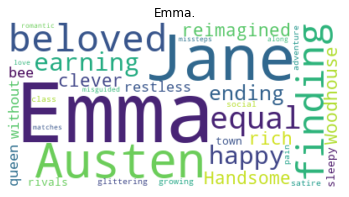

In [75]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
wc = WordCloud(stopwords=stop_words,background_color='white').generate(movie_book_df2.iloc[idx]['plot/book_desc'])
plt.imshow(wc, interpolation='bilinear')
plt.title(movie_book_df2.iloc[idx]['title'].title())
plt.axis("off")
plt.show();

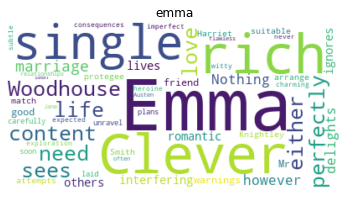

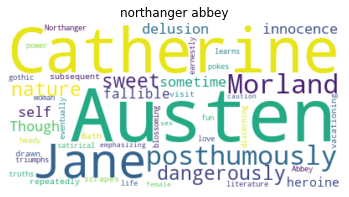

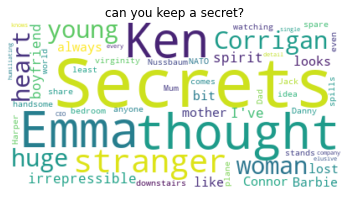

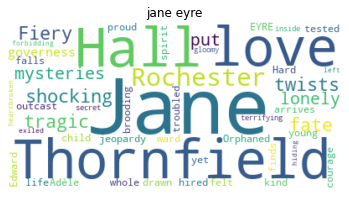

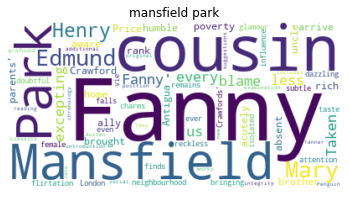

In [76]:
from wordcloud import WordCloud


for i in movie_indices:
    wc = WordCloud(stopwords=stop_words,background_color='white').generate(movie_book_df2.iloc[i]['plot/book_desc'])
    plt.imshow(wc, interpolation='bilinear')
    plt.title(movie_book_df2.iloc[i]['title'])
    plt.axis("off")
    plt.show();

## Reccomender w/ CountVectorizer

In [173]:
from sklearn.feature_extraction.text import CountVectorizer

class NLPPipe:
   
    def __init__(self, vectorizer= CountVectorizer(), tokenizer=None, cleaning_function=None, 
                 lemmatizer=None,model=None):
        if not tokenizer:
            tokenizer = self.splitter
        if not cleaning_function:
            cleaning_function = self.clean_text
        self.lemmatizer = lemmatizer
        self.tokenizer = tokenizer
        self.model = model
        self.cleaning_function = cleaning_function
        self.vectorizer = vectorizer
        self._is_fit = False
        
    def splitter(self, text):
        return text.split(' ')
        
 
    
    def fit_transform(self, text):
        clean_text = self.cleaning_function(text, self.tokenizer, self.lemmatizer)
        return self.vectorizer.fit_transform(clean_text)

In [174]:
nlp = NLPPipe(vectorizer=CountVectorizer(stop_words = stop_words,max_df=0.5,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

count_result = nlp.fit_transform(corpus)

In [176]:
count_result.shape

(16200, 895959)

## PUT THIS IN A FUNCTION BEFORE SUBMITTING

In [18]:
 cosine_similarities = cosine_similarity(count_result, count_result)

In [19]:
import numpy as np
np.percentile( cosine_similarities[:,0],1)

# whatever the value is at that percentile, set everything above that equal to zero
cos_dist_df = pd.DataFrame(cosine_similarities)
cos_dist_df[cos_dist_df>1.5] = 0

import scipy.sparse
sparse_mat = scipy.sparse.csc_matrix(cos_dist_df)

In [25]:
reccomend,movie_indices,idx = recommendations('the lord of the rings')
reccomend

[1410, 10204, 9580, 2182, 10615]


1410                                       Throne of Blood
10204    The Lord of the Rings: The Fellowship of the Ring
9580                                             Annamayya
2182                                        Agent Shiranui
10615        The Lord of the Rings: The Return of the King
Name: title, dtype: object

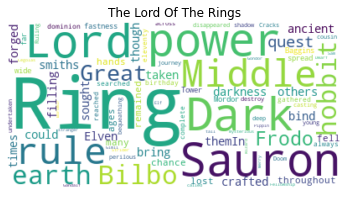

In [188]:
wc = WordCloud(stopwords=stop_words,background_color='white').generate(movie_book_df2.iloc[idx]['plot/book_desc'])
plt.imshow(wc, interpolation='bilinear')
plt.title(movie_book_df2.iloc[idx]['title'].title())
plt.axis("off")
plt.show();

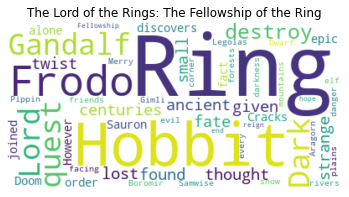

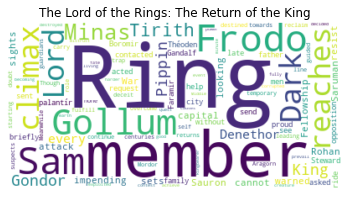

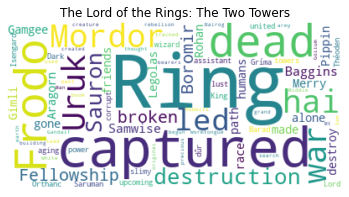

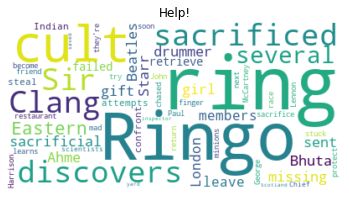

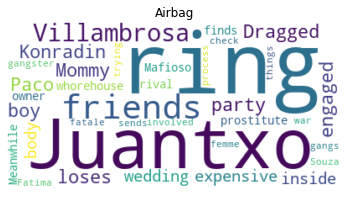

In [187]:
for i in movie_indices:
    wc = WordCloud(stopwords=stop_words,background_color='white').generate(movie_book_df2.iloc[i]['plot/book_desc'])
    plt.imshow(wc, interpolation='bilinear')
    plt.title(movie_book_df2.iloc[i]['title'])
    plt.axis("off")
    plt.show();

In [189]:
reccomend,movie_indices,idx = recommendations('gone with the wind')
reccomend

[3776, 8645, 1502, 4594, 9111]


3776    Täällä Pohjantähden alla
8645                  Gettysburg
1502              Band of Angels
4594            Georgia, Georgia
9111            Land and Freedom
Name: title, dtype: object

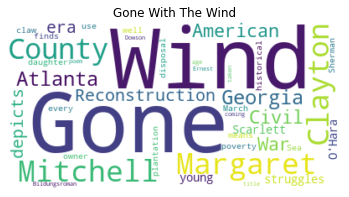

In [190]:
wc = WordCloud(stopwords=stop_words,background_color='white').generate(movie_book_df2.iloc[idx]['plot/book_desc'])
plt.imshow(wc, interpolation='bilinear')
plt.title(movie_book_df2.iloc[idx]['title'].title())
plt.axis("off")
plt.show();

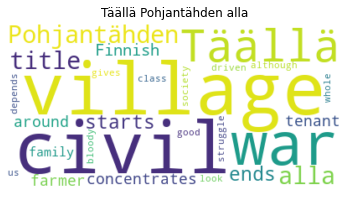

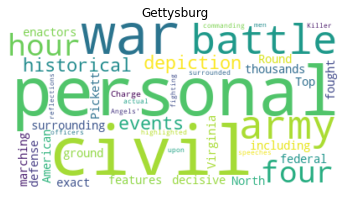

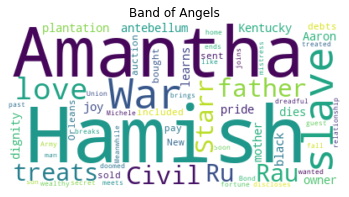

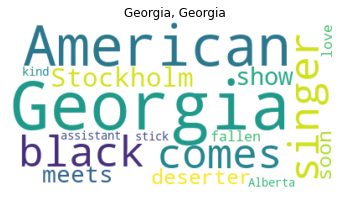

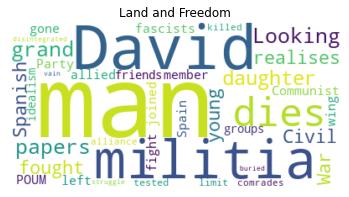

In [191]:
for i in movie_indices:
    wc = WordCloud(stopwords=stop_words,background_color='white').generate(movie_book_df2.iloc[i]['plot/book_desc'])
    plt.imshow(wc, interpolation='bilinear')
    plt.title(movie_book_df2.iloc[i]['title'])
    plt.axis("off")
    plt.show();

In [21]:
nlp = NLPPipe(vectorizer=CountVectorizer(stop_words = stop_words,min_df=0.01,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

count_result = nlp.fit_transform(corpus)

In [22]:
 cosine_similarities = cosine_similarity(count_result, count_result)

In [23]:
import numpy as np
np.percentile( cosine_similarities[:,0],1)

# whatever the value is at that percentile, set everything above that equal to zero
cos_dist_df = pd.DataFrame(cosine_similarities)
cos_dist_df[cos_dist_df>1.5] = 0

import scipy.sparse
sparse_mat = scipy.sparse.csc_matrix(cos_dist_df)

In [26]:
reccomend,movie_indices,idx = recommendations('the lord of the rings')
reccomend

[1410, 10204, 9580, 2182, 10615]


1410                                       Throne of Blood
10204    The Lord of the Rings: The Fellowship of the Ring
9580                                             Annamayya
2182                                        Agent Shiranui
10615        The Lord of the Rings: The Return of the King
Name: title, dtype: object

In [27]:
reccomend,movie_indices,idx = recommendations('gone with the wind')
reccomend

[2512, 3955, 11538, 9111, 4216]


2512                                    A Monkey in Winter
3955     Il Prof. Dott. Guido Tersilli primario della C...
11538                                        Mister Lonely
9111                                      Land and Freedom
4216                                          The Beguiled
Name: title, dtype: object

In [28]:
reccomend,movie_indices,idx = recommendations('the hunger games')
reccomend

[6774, 13561, 8602, 10538, 983]


6774     The Terence Davies Trilogy
13561         Blade of the Immortal
8602            A Morte do Príncipe
10538                  September 11
983                   Boris Godunov
Name: title, dtype: object

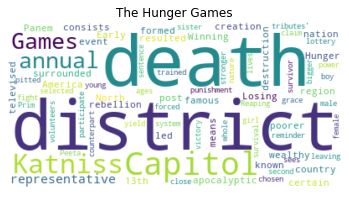

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
wc = WordCloud(stopwords=stop_words,background_color='white').generate(movie_book_df2.iloc[idx]['plot/book_desc'])
plt.imshow(wc, interpolation='bilinear')
plt.title(movie_book_df2.iloc[idx]['title'].title())
plt.axis("off")
plt.show();

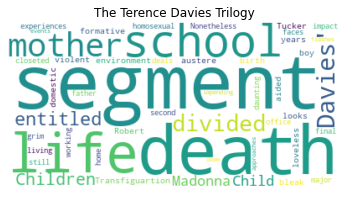

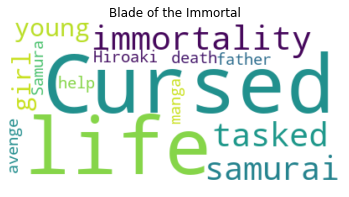

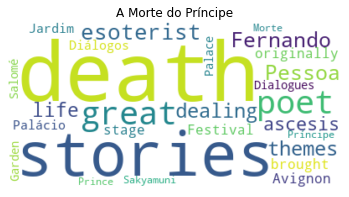

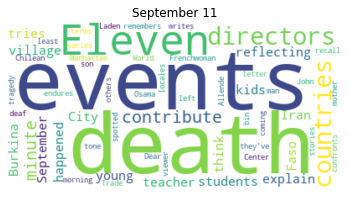

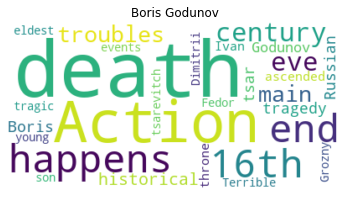

In [32]:
for i in movie_indices:
    wc = WordCloud(stopwords=stop_words,background_color='white').generate(movie_book_df2.iloc[i]['plot/book_desc'])
    plt.imshow(wc, interpolation='bilinear')
    plt.title(movie_book_df2.iloc[i]['title'])
    plt.axis("off")
    plt.show();

### TruncatedSVD

In [117]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=5000)
tf_result_svd = svd.fit_transform(tf_result)
exp_variances = svd.explained_variance_ratio_.cumsum()

KeyboardInterrupt: 

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(exp_variances);
plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance")

In [ ]:
tf_result_svd = tf_result_svd[:, :1000]

In [ ]:
 cosine_similarities = cosine_similarity(tf_result_svd, tf_result_svd)

In [ ]:
import numpy as np
np.percentile( cosine_similarities[:,0],1)

# whatever the value is at that percentile, set everything above that equal to zero
cos_dist_df = pd.DataFrame(cosine_similarities)
cos_dist_df[cos_dist_df>1.5] = 0

import scipy.sparse
sparse_mat = scipy.sparse.csc_matrix(cos_dist_df)

In [ ]:
reccomend,movie_indices,idx = recommendations('little women')
reccomend

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
wc = WordCloud(stopwords=stop_words,background_color='white').generate(movie_book_df2.iloc[idx]['plot/book_desc'])
plt.imshow(wc, interpolation='bilinear')
plt.title(movie_book_df2.iloc[idx]['title'].title())
plt.axis("off")
plt.show();

In [ ]:
for i in movie_indices:
    wc = WordCloud(stopwords=stop_words,background_color='white').generate(movie_book_df2.iloc[i]['plot/book_desc'])
    plt.imshow(wc, interpolation='bilinear')
    plt.title(movie_book_df2.iloc[i]['title'])
    plt.axis("off")
    plt.show();

In [ ]:
reccomend,movie_indices,idx = book_recommendations('Cinderella')
reccomend

In [ ]:
idx

In [ ]:
wc = WordCloud(stopwords=stop_words,background_color='white').generate(movie_book_df2.iloc[idx[0]]['plot/book_desc'])
plt.imshow(wc, interpolation='bilinear')
plt.title(movie_book_df2.iloc[idx[0]]['title'].title())
plt.axis("off")
plt.show();

In [ ]:
for i in movie_indices:
    wc = WordCloud(stopwords=stop_words,background_color='white').generate(movie_book_df2.iloc[i]['plot/book_desc'])
    plt.imshow(wc, interpolation='bilinear')
    plt.title(movie_book_df2.iloc[i]['title'])
    plt.axis("off")
    plt.show();

## No N-GRAMS

In [112]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,max_df=0.5), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(corpus)

/Users/sibongiletoure/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['printr', 'δι', 'арбаң', 'арсалаң', 'батыр', 'бүгжең', 'бұтыр', 'далаң', 'ербелең', 'жалт', 'жұлт', 'күңгір', 'митың', 'онан', 'паһ', 'салаң', 'сұлаң', 'сұрт', 'тарбаң', 'тыржың', 'тұрс', 'шұңқ', 'ыржың', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'әттеген', 'ἀλλ'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [113]:
 cosine_similarities = cosine_similarity(tf_result, tf_result)

In [114]:
import numpy as np
# get pairwise distances from array or df
#song_similarities = pairwise_distances(pca_data[:,:8])
# find the nth percentile distance so you can set the rest to zero
np.percentile( cosine_similarities[:,0],1)

# whatever the value is at that percentile, set everything above that equal to zero
cos_dist_df = pd.DataFrame(cosine_similarities)
cos_dist_df[cos_dist_df>1.5] = 0

# make sparse matrix
import scipy.sparse
sparse_mat = scipy.sparse.csc_matrix(cos_dist_df)

In [115]:
reccomend,movie_indices,idx = recommendations('little women')
reccomend

[4787, 8816, 13822, 9002, 12987]


4787             Mujercitas
8816           Little Women
13822          Little Women
9002     Indradhanura Chhai
12987               4 Moons
Name: title, dtype: object

In [116]:
reccomend,movie_indices,idx = book_recommendations('Cinderella')
reccomend

[14435, 16147, 15385, 15083, 15993]


14435                       ella enchanted
16147    confessions of an ugly stepsister
15385                           masquerade
15083                         lock and key
15993                       witches abroad
Name: title, dtype: object